# Preparing data for interactive plots

In [2]:
# Get packages
using CSV, DataFrames, wgregseq, CairoMakie, Statistics, DelimitedFiles, Dates, Colors, FASTX, BioSequences, ProgressMeter

# Set colors and plotting style
wgregseq.viz.default_makie!()
update_theme!(Theme(font = "Lato", titlefont="Lato"))
colors_dict = wgregseq.viz.my_color_dict
colors = [colors_dict["blue1"], colors_dict["orange1"], colors_dict["green1"]]

3-element Vector{String}:
 "#324fa2"
 "#f47c20"
 "#a8cf38"

## Import mapping data

Import the table mapping barcodes to promoter variants and filter out anything that has less than 3 reads, as well as anything with more than 30 mutations.

In [2]:
df_map = CSV.read(
    "../../../data/barcode_maps/20220514_mapping/mapped_barcodes_filtered.csv", 
    DataFrame, 
);

In [3]:
# Filter out unnannotad sequences
df_map = df_map[df_map.name .!= "*", :]

# Filter out non-unique barcodes
gdf = groupby(df_map[(df_map.counts .> 2), :], :barcode)
_df = DataFrame()
for df in gdf
    if nrow(df) == 1
        append!(_df, df)
    end
end
df_map = copy(_df);

In [4]:
df_map

Row,promoter,barcode,counts,name
,String,String31,Int64,String
1,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,TTGTTATGATTTATTCTATG,183,TSS_1414_storz_regulondb
2,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,AGCAACGTCTACGTTGGTAT,146,TSS_1414_storz_regulondb
3,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,AAGCAACTCGCTGAAGAATT,141,TSS_1414_storz_regulondb
4,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,GATCTCCCTGCTCTGGAATG,128,TSS_1414_storz_regulondb
5,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,AGGGGGAATCAAGTAACTTA,108,TSS_1414_storz_regulondb
6,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,GGGTAGATCGGACCTGCAGG,107,TSS_1414_storz_regulondb
7,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,TTACTCTTCTCGCCTTTTTA,96,TSS_1414_storz_regulondb
8,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,GCAGTTACGCGTGAAAATGT,84,TSS_1414_storz_regulondb
9,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG,CAGCAGCTGCCATTTGAAAG,71,TSS_1414_storz_regulondb


In [5]:
# Get twist order to get wild type sequences
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

df_wt.promoter_seq |> unique |> length
df_map = leftjoin(df_map, rename(df_wt[!, [:promoter, :promoter_seq]], :promoter => :name), on="name")
rename!(df_map, :promoter_seq => :wt_seq);

## Import barcode data

In [30]:
# initiate dataframes

ind = collect(Iterators.product(collect(1:4), collect(-115:44))) |> vec

# iterate through growth conditions
for gc_ind in gcs
    df_footprints = DataFrame()
    df_exshift = DataFrame()
    gc, info, rep = get_gc_info(gc_ind)
    df = get_dataset(gc_ind)
    println(gc_ind)
    for (i, prom) in enumerate(unique(df.name))
        wt_seq = df_wt[df_wt.promoter .== prom, :promoter_seq][1]
        ind_wt = collect(Iterators.product(collect(1:4), collect(wt_seq))) |> vec
        # get mutual information
        x = wgregseq.footprints.mutual_information_mutation(df[df.name .== prom, :], vec=true)
        # get expression shift
        ex_shift = wgregseq.footprints.expression_shift_matrix(df[df.name .== prom, :], vec=true)
        #ex_shift ./= maximum(abs.(ex_shift))
        # add mutual information to dataframe
        append!(
            df_footprints,
            DataFrame( 
                promoter=prom, 
                mut_info=x,
                growth_condition=gc,
                growth_condition_info=info,
                replicate=rep, 
                pos=collect(-115:44), 
                d="0")
        )

        append!(
            df_exshift,
            DataFrame( 
                promoter=prom, 
                expression_shift=ex_shift' |> vec , 
                growth_condition=gc,
                growth_condition_info=info,
                replicate=rep,
                pos=[t[2] for t in ind],
                base=[t[1] for t in ind],
                wt_base=[t[2] for t in ind_wt]
            )
        )
        for d in 1:2
            append!(
                df_footprints,
                DataFrame( 
                    promoter=prom, 
                    mut_info=[mean(x[i-d:i+d]) for i in 1+d:160-d], 
                    growth_condition=gc,
                    growth_condition_info=info,
                    replicate=rep, 
                    pos=collect(-115+d:44-d), 
                    d="$d"
                )
            )
        end
    end
    println("$(gc_ind) done")
    CSV.write("footprints/$(gc_ind)_footprints.csv", df_footprints)
    CSV.write("expression_shifts/$(gc_ind)_exshifts.csv", df_exshift)
end

11-2
11-2 done
21-1
21-1 done
4-2
4-2 done
1-1
1-1 done
10-1
10-1 done
12-1
12-1 done
13-1
13-1 done
2-1
2-1 done
3-1
3-1 done
5-1
5-1 done
6-1
6-1 done
7-1
7-1 done
1-2
1-2 done
13-2
13-2 done
14-1
14-1 done
15-1
15-1 done
16-1
16-1 done
17-1
17-1 done
18-1
18-1 done
19-1
19-1 done
19-2
19-2 done
2-2
2-2 done
20-1
20-1 done
22-1
22-1 done
23-1
23-1 done
24-1
24-1 done
25-1
25-1 done
26-1
26-1 done
28-1
28-1 done
29-1
29-1 done
3-2
3-2 done
30-1
30-1 done
32-1
32-1 done
33-1
33-1 done
35-1
35-1 done
36-1
36-1 done
37-1
37-1 done
4-1
4-1 done
9-1
9-1 done
14-3
14-3 done
15-3
15-3 done
19-3
19-3 done
22-3
22-3 done
25-3
25-3 done
31-3
31-3 done
38-3
38-3 done
4-3
4-3 done
40-3
40-3 done
41-1
41-1 done
41-2
41-2 done
8-2
8-2 done
10-2
10-2 done
11-1
11-1 done
12-2
12-2 done
13-3
13-3 done
14-2
14-2 done
15-2
15-2 done
16-2
16-2 done
17-2
17-2 done
18-2
18-2 done
20-2
20-2 done
21-2
21-2 done
22-2
22-2 done
23-2
23-2 done
24-2
24-2 done
25-2
25-2 done
26-2
26-2 done
28-2
28-2 done
29-2
29-

In [30]:
200%100

0

## Metadata

In [36]:
df_twist = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
unique(df_twist[!, [:genes, :promoter]])

wt_seqs = df_twist[1:1501:end, :]

# Import genome
re = open(FASTA.Reader, "../../../data/ecocyc/mg1655_genome.fasta")
wt_sequence = [sequence(record) for record in re][1]

"AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAAC" ⋯ 4641115 bytes ⋯ "GATGGTCTATTGCTATCAATTAGCAACATTAATACAACAACCGGCGAAAAGTGATGCAACGGCAGACCAACATCAACTGCAAGCTTTACGCGAACGAGCCATGACATTGCTGACGACTCTGGCAGTGGCAGATGACATAAAACTGGTCGACTGGTTACAACAACGCCTGGGGCTTTTAGAGCAACGAGACACGGCAATGTTGCACCGTTTGCTGCATGATATTGAAAAAAATATCACCAAATAAAAAACGCCTTAGTAAGTATTTTTC"

In [37]:
five_prime = []
three_prime = []
direction = []
promoter = []
genes = []
promoter_seq = []
for i in 1:119
    fwd = findall(string(wt_seqs[i, :sequence][27:186]), string(wt_sequence))
    rev = findall(reverse_complement(string(wt_seqs[i, :sequence][27:186])), string(wt_sequence))
    if length(fwd) == 0 && length(rev) == 0
        throw(ErrorException("Sequence not found for promoter $(wt_seqs[i, :promoter])!"))
    elseif length(fwd) > 0 && length(rev) > 0
        throw(ErrorException("Sequence found on both strands for promoter $(wt_seqs[i, :promoter])!"))
    elseif length(fwd) > 0
        push!(five_prime, fwd[1][1])
        push!(three_prime, fwd[1][end])
        push!(direction, '+')
        push!(promoter, wt_seqs[i, :promoter])
        push!(genes, join(wt_seqs[i, :genes], ", "))
        push!(promoter_seq, wt_seqs[i, :sequence][27:186])
    else
        push!(three_prime, rev[1][1])
        push!(five_prime, rev[1][end])
        push!(direction, '-')
        push!(promoter, wt_seqs[i, :promoter])
        push!(genes, join(wt_seqs[i, :genes], ", "))
        push!(promoter_seq, wt_seqs[i, :sequence][27:186])
    end
end

df_meta = DataFrame(five_prime=five_prime, three_prime=three_prime, direction=direction, promoter=promoter, genes=genes, promoter_seq=promoter_seq)
CSV.write("../../figures/interactive_footprints/20231207_footprints_meta.csv", df_meta)

"../../figures/interactive_footprints/20231207_footprints_meta.csv"

In [23]:
df_ldr = get_dataset("3-1")
df_ldr = df_ldr[df_ldr.name .== "ldrDp", :]

160×4 Matrix{Float64}:
 -0.0123678    0.0         0.0110704   -0.144165
  0.0         -0.0659984  -0.197025     0.0153286
  0.0475796   -0.122976    0.0          0.0621473
  0.0244123    0.0         0.127499     0.126345
 -0.0727224    0.0         0.0506109   -0.212283
 -0.0747943    0.0         0.0393369   -0.0338808
  0.0125881    0.0232832   0.0          0.137237
 -0.158869    -0.141819    0.0          0.109055
  0.0         -0.191052   -0.163982    -0.147004
 -0.168698    -0.0555237   0.140353     0.0
  0.0         -0.134414   -0.118038    -0.129217
 -0.239238    -0.205616    0.0381176    0.0
  0.0475433   -0.0409218   0.0         -0.0517556
  ⋮                                    
  0.14341      0.0381539   0.0         -0.081123
 -0.138689     0.261078    0.0          0.136912
 -0.157404     0.192493    0.0         -0.0644231
  0.0272601    0.0490106   0.0          0.0699887
 -0.0773604   -0.250685    0.0          0.0598548
  0.108625     0.0         0.00454482   0.0750416
 -0.0807

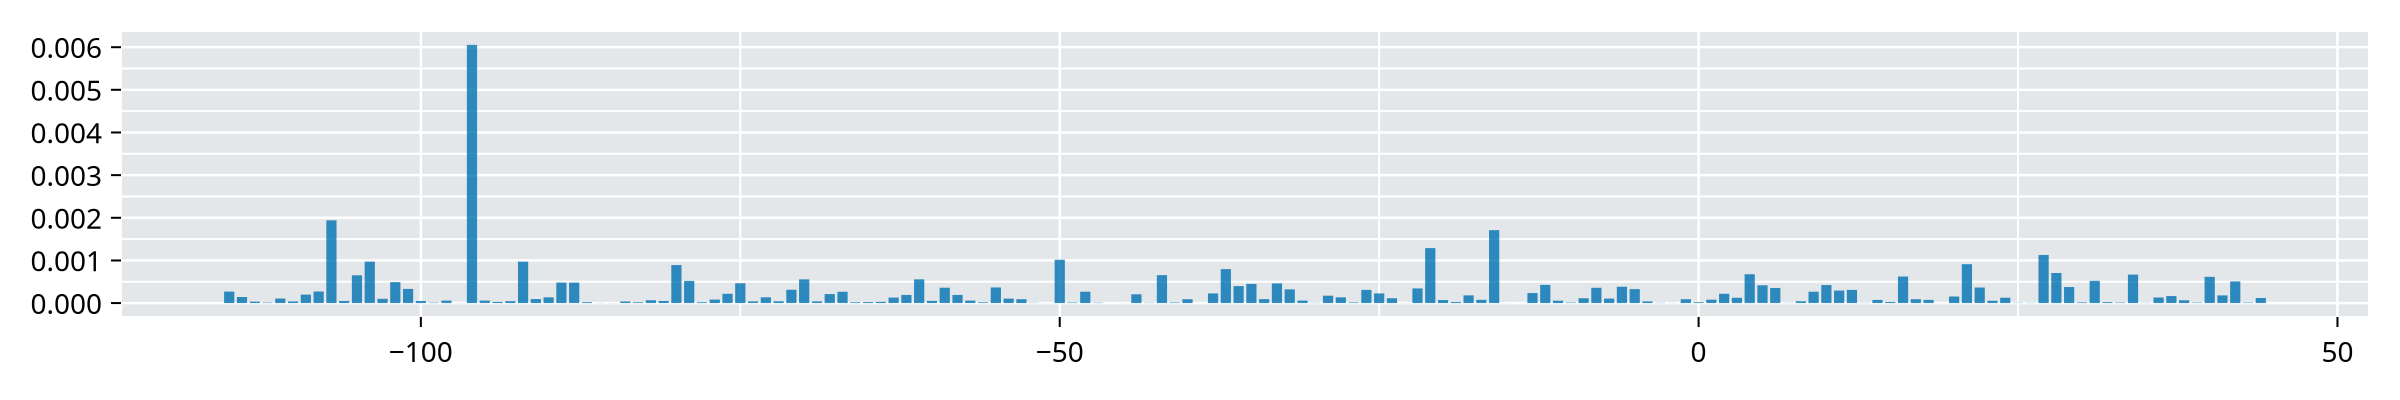

In [26]:

x = wgregseq.footprints.mutual_information_mutation(df_ldr)
# get expression shift
ex_shift = expression_shift_matrix(df_ldr)

fig = Figure(size=(1200, 200))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, x)
fig

In [ ]:
df_temp = df_ldr[df
x = wgregseq.footprints.mutual_information_mutation(df_temp)
# get expression shift
ex_shift = expression_shift_matrix(df_ldr)

fig = Figure(size=(1200, 300))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, x)
fig